### Loading images
https://www.tensorflow.org/tutorials/load_data/images

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import numpy as np
import datetime
import time
import os
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import datetime

# Some stuff to make utils-function work
import sys
sys.path.append('../utils')
from pipeline import *
from create_model import *
from utils import *
%load_ext autoreload
%autoreload 2

# Jupyter-specific
%matplotlib inline

project_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

Some parameters

In [2]:
# data_dir = pathlib.Path('/home/henriklg/master-thesis/data/kvasir-v2/')
data_dir = pathlib.Path('/home/henriklg/master-thesis/data/hyper-kvasir/labeled_ttv/')

dir_name = "resnet50"
experiment = "imbalance"
log_dir = "./logs/{}_{}/{}".format(project_time, experiment, dir_name)

conf = {
    # Dataset
    "data_dir": data_dir,
    "ds_info": 'binary',
    "augment": ["crop","flip","brightness","saturation","contrast","rotate"],
    "aug_mult": 0,
    "resample": False,
    "class_weight": False,
    "shuffle_buffer_size": 2000,        # 0=no shuffling
    "seed": 2511,
    "neg_class": "pylorus",                 # select neg class for binary ds (normal class)
    "outcast": None,                   # list of folders to drop - currently only works for 1 item
    # Model
    "model": 'EfficientNetB0',
    "weights": None,                   # which weights to initialize the model with
    "dropout": 0.2,
    "num_epochs": 10,
    "batch_size": 16,
    "img_shape": (128, 128, 3),
    "learning_rate": 0.001,
    "optimizer": 'Adam',
    "final_activation": 'sigmoid',     # sigmoid for binary ds
    # Callbacks
    "tensorboard": False,
    "learning_schedule": False,
    "decay_rate": 0,                   # 128:0.25   64:1.0   32:4.0   16:16   8:64
    "checkpoint": False,
    "early_stopp": False,
    "early_stopp_patience": 7,
    # Misc
    "verbosity": 1,
    "keep_threshold": 0.0,
    "log_dir": log_dir,
    "cache_dir": "./cache"
    }

Create training, testing and validation dataset from utils/data_prep.py

In [3]:
ds = create_dataset(conf)


Negative                          :   999 | 9.37%
---------------------------------------------
     - pylorus                    :   999 | 9.37%

Positive                          :  9663 | 90.63%
---------------------------------------------
     - barretts-short-segment     :    53 | 0.50%
     - retroflex-stomach          :   764 | 7.17%
     - ulcerative-colitis-0-1     :    35 | 0.33%
     - ulcerative-colitis-grade-3 :   133 | 1.25%
     - esophagitis-b-d            :   260 | 2.44%
     - dyed-resection-margins     :   989 | 9.28%
     - hemorrhoids                :     6 | 0.06%
     - normal-z-line              :   932 | 8.74%
     - esophagitis-a              :   403 | 3.78%
     - ulcerative-colitis-1-2     :    11 | 0.10%
     - barretts                   :    41 | 0.38%
     - bbps-2-3                   :  1148 | 10.77%
     - ileum                      :     9 | 0.08%
     - bbps-0-1                   :   646 | 6.06%
     - impacted-stool             :   131 | 1.23%
    

# Training

### Resnet50 transfer learning
see https://adventuresinmachinelearning.com/transfer-learning-tensorflow-2/  
imbalanced-data: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

In [4]:
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, LearningRateScheduler

In [5]:
metrics = [
        tf.keras.metrics.TruePositives(name='tp'),
        tf.keras.metrics.FalsePositives(name='fp'),
        tf.keras.metrics.TrueNegatives(name='tn'),
        tf.keras.metrics.FalseNegatives(name='fn'), 
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc'),
]

In [6]:
res_net = tf.keras.applications.ResNet50(
                weights='imagenet', 
                include_top=False, 
                input_shape=conf["img_shape"])

res_net.trainable = True

In [7]:
def make_model(output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    
    global_average_layer = GlobalAveragePooling2D()
    output_layer = Dense(1, activation=conf["final_activation"],
                         bias_initializer=output_bias)

    resnet50_model = tf.keras.Sequential([
            res_net,
            global_average_layer,
            output_layer])
    
    if conf['optimizer'] == 'Adam':
        opt = tf.keras.optimizers.Adam(learning_rate=conf["learning_rate"])
    elif conf['optimizer'] == 'SGD':
        opt = tf.keras.optimizers.SGD(learning_rate=conf["learning_rate"])

    resnet50_model.compile(
            optimizer=opt,
            loss=tf.keras.losses.BinaryCrossentropy(),
            metrics=metrics)
    
    return resnet50_model

### Callbacks

In [8]:
callbacks = create_callbacks(conf)

## Set correct initial bias


In [9]:
bias_model = make_model()

# Test run the model and show 10 first predictions of one epoch
bias_model.predict(ds["train"].take(1))[:10]

array([[0.16182473],
       [0.16980207],
       [0.17290497],
       [0.1681541 ],
       [0.17086743],
       [0.17005058],
       [0.16597866],
       [0.17113271],
       [0.17005381],
       [0.1708837 ]], dtype=float32)

In [10]:
results = bias_model.evaluate(ds["train"], verbose=0, steps=conf["steps"]["train"])
print("Loss: {:0.4f}".format(results[0]))

Loss: 1.6231


In [11]:
initial_bias = np.log([conf["pos_count"]/conf["neg_count"]])
print ("The initial bias should then be: {:.4f}".format(initial_bias[0]))

The initial bias should then be: 2.2693


In [12]:
new_bias_model = make_model(output_bias = initial_bias)
new_bias_model.predict(ds["train"], verbose=0, steps=conf["steps"]["train"])

print ("Initial guess should be around:", conf["pos_count"]/conf["ds_sizes"]["total"])
new_bias_model.predict(ds["train"].take(1))[:10]

Initial guess should be around: 0.9063027574563872


array([[0.93139756],
       [0.9313035 ],
       [0.9309217 ],
       [0.9301199 ],
       [0.93065846],
       [0.930574  ],
       [0.93035424],
       [0.9308209 ],
       [0.9314193 ],
       [0.9312885 ]], dtype=float32)

In [13]:
results = new_bias_model.evaluate(ds["train"], verbose=0, steps=conf["steps"]["train"])
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.3165


In [14]:
initial_weights = os.path.join(conf["log_dir"],'initial_weights')
new_bias_model.save_weights(initial_weights)

#### Confirm that the bias fix helps

In [15]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_loss(history, label, n):
    # Use a log scale to show the wide range of values.
    plt.semilogy(history.epoch,  history.history['loss'],
               color=colors[n], label='Train '+label)
    plt.semilogy(history.epoch,  history.history['val_loss'],
          color=colors[n], label='Val '+label,
          linestyle="--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend()

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Some functions

In [17]:
def plot_metrics(history):
    metrics =  ['loss', 'auc', 'precision', 'recall']
    plt.figure(figsize=(12, 10))
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

        plt.legend()
    plt.tight_layout()

In [18]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    
    metrics_list = np.asarray([['tn', 'fp'], ['fn', 'tp']])
    labels = (np.asarray(["{0}\n{1:.0f}".format(metrics_list,cm) for metrics_list, cm in zip(metrics_list.flatten(), cm.flatten())])).reshape(2,2)
    
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=labels, fmt="", robust=True, annot_kws={'size':16})
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    
    plt.ylim(2,0)

    print('Legitimate Lesions Detected (True Negatives): ', cm[0][0])
    print('Legitimate Lesions Incorrectly Detected (False Positives): ', cm[0][1])
    print('Fraudulent Lesions Missed (False Negatives): ', cm[1][0])
    print('Fraudulent Lesions Detected (True Positives): ', cm[1][1])
    print('Total Fraudulent Lesions: ', np.sum(cm[1]))
    print()

In [19]:
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = roc_curve(labels, predictions)

    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([-0.5,20])
    plt.ylim([80,100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.tight_layout()

In [20]:
def numpify(dataset, model, samples=4000):
    ds_eval = dataset.unbatch().take(samples)
    labels = []
    images = []
    for img, lab in ds_eval:
        labels.append(lab.numpy())
        images.append(img.numpy())

    pred = model.predict(np.expand_dims(images, axis=0)[-1])
    
    return (labels, pred)

## Baseline

In [21]:
baseline_model = make_model()
baseline_model.load_weights(initial_weights)

write_to_file(conf, conf, "conf")

baseline_history = baseline_model.fit(
    ds["train"],
    steps_per_epoch = conf["steps"]["train"],
    epochs = conf["num_epochs"],
    validation_data = ds["test"],
    validation_steps = conf["steps"]["test"],
    validation_freq = 1,
    callbacks = callbacks
)

Train for 465 steps, validate for 99 steps
Epoch 1/10
465/465 [==============================] - 33s 72ms/step - loss: 0.1398 - tp: 6640.0000 - fp: 287.0000 - tn: 409.0000 - fn: 104.0000 - accuracy: 0.9474 - precision: 0.9586 - recall: 0.9846 - auc: 0.9559 - val_loss: 6.9511 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 148.0000 - val_fn: 1436.0000 - val_accuracy: 0.0934 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000
Epoch 2/10
465/465 [==============================] - 27s 59ms/step - loss: 0.0828 - tp: 6640.0000 - fp: 154.0000 - tn: 546.0000 - fn: 100.0000 - accuracy: 0.9659 - precision: 0.9773 - recall: 0.9852 - auc: 0.9864 - val_loss: 2.3040 - val_tp: 267.0000 - val_fp: 0.0000e+00 - val_tn: 147.0000 - val_fn: 1170.0000 - val_accuracy: 0.2614 - val_precision: 1.0000 - val_recall: 0.1858 - val_auc: 0.9496
Epoch 3/10
465/465 [==============================] - 27s 58ms/step - loss: 0.0567 - tp: 6682.0000 - fp: 91.0000 - tn: 604.0000 - fn: 63.0000 - accurac

#### Validate the results

In [22]:
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns

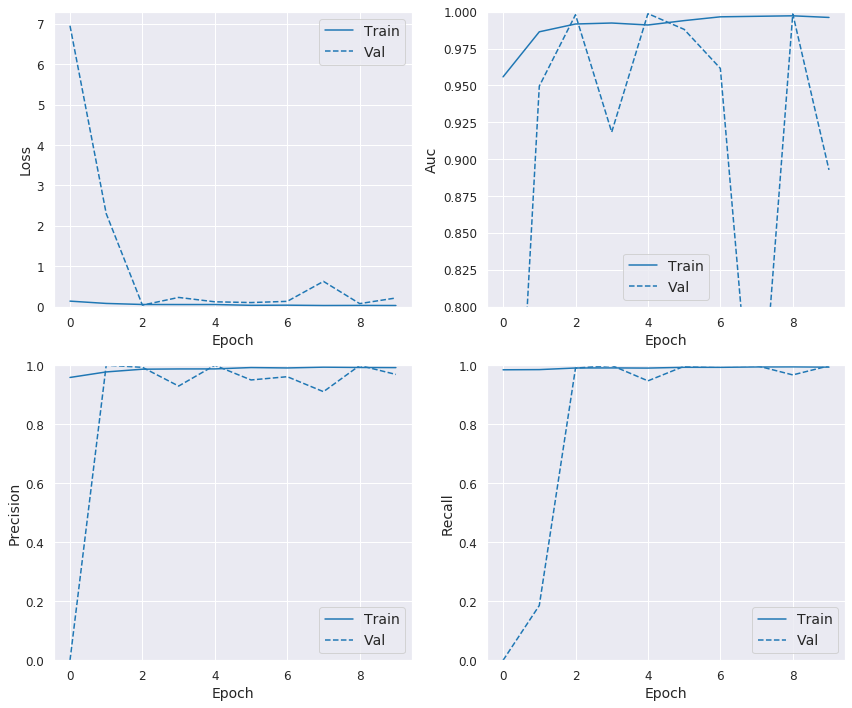

In [24]:
plot_metrics(baseline_history)
plt.savefig(conf["log_dir"]+"/baseline_metrics_plot")

In [25]:
baseline_results = baseline_model.evaluate(ds["val"], verbose=2, steps=conf["steps"]["val"])
print()

f = open(conf["log_dir"]+"/baseline_val_results.txt","w")
for name, value in zip(baseline_model.metrics_names, baseline_results):
    line = "{} : {}\n".format(name, value)
    print(line, end='')
    f.write(line)
f.close()
print()

100/100 - 2s - loss: 0.0295 - tp: 1447.0000 - fp: 5.0000 - tn: 141.0000 - fn: 7.0000 - accuracy: 0.9925 - precision: 0.9966 - recall: 0.9952 - auc: 0.9993

loss : 0.029475939797703177
tp : 1447.0
fp : 5.0
tn : 141.0
fn : 7.0
accuracy : 0.9925000071525574
precision : 0.9965564608573914
recall : 0.9951856732368469
auc : 0.9992793202400208



In [26]:
train_labels_baseline, train_predictions_baseline = numpify(ds["train"], baseline_model, samples=5000)
val_labels_baseline, val_predictions_baseline = numpify(ds["val"], baseline_model, samples=5000)

Legitimate Lesions Detected (True Negatives):  395
Legitimate Lesions Incorrectly Detected (False Positives):  68
Fraudulent Lesions Missed (False Negatives):  28
Fraudulent Lesions Detected (True Positives):  4509
Total Fraudulent Lesions:  4537



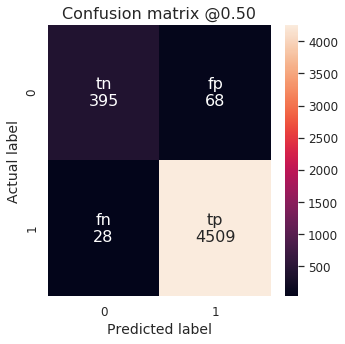

In [27]:
plot_cm(train_labels_baseline, train_predictions_baseline)
plt.savefig(conf["log_dir"]+"/baseline_cm_plot")

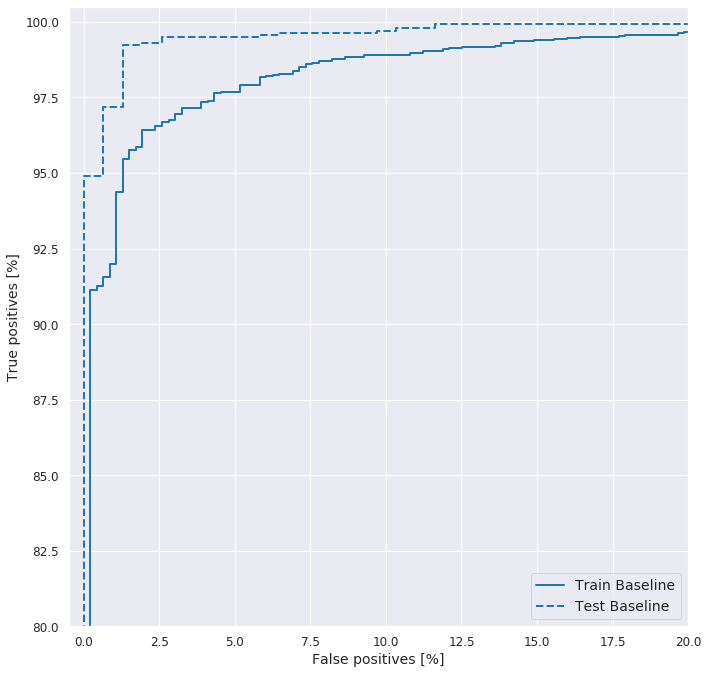

In [28]:
plt.figure(figsize=(10,10))

plot_roc("Train Baseline", train_labels_baseline, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", val_labels_baseline, val_predictions_baseline, color=colors[0], linestyle='--')

plt.legend(loc='lower right');
plt.savefig(conf["log_dir"]+"/baseline_roc_plot.pdf", format="pdf")

### Calculate class weights
See https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#class_weights

In [29]:
weight_for_0 = (1/conf["neg_count"])*(conf["ds_sizes"]["total"])/2.0
weight_for_1 = (1/conf["pos_count"])*(conf["ds_sizes"]["total"])/2.0

class_weight = {0: weight_for_0,
                1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 5.34
Weight for class 1: 0.55


In [30]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    ds["train"],
    steps_per_epoch = conf["steps"]["train"],
    epochs = conf["num_epochs"],
    validation_data = ds["test"],
    validation_steps = conf["steps"]["test"],
    validation_freq = 1,
    class_weight = class_weight,
    callbacks = callbacks
)

Train for 465 steps, validate for 99 steps
Epoch 1/10
465/465 [==============================] - 32s 70ms/step - loss: 0.2395 - tp: 6115.0000 - fp: 58.0000 - tn: 639.0000 - fn: 628.0000 - accuracy: 0.9078 - precision: 0.9906 - recall: 0.9069 - auc: 0.9666 - val_loss: 2.1491 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 149.0000 - val_fn: 1435.0000 - val_accuracy: 0.0941 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5906
Epoch 2/10
465/465 [==============================] - 26s 56ms/step - loss: 0.2220 - tp: 6107.0000 - fp: 59.0000 - tn: 638.0000 - fn: 636.0000 - accuracy: 0.9066 - precision: 0.9904 - recall: 0.9057 - auc: 0.9720 - val_loss: 1.5120 - val_tp: 208.0000 - val_fp: 0.0000e+00 - val_tn: 149.0000 - val_fn: 1227.0000 - val_accuracy: 0.2254 - val_precision: 1.0000 - val_recall: 0.1449 - val_auc: 0.9329
Epoch 3/10
465/465 [==============================] - 27s 58ms/step - loss: 0.1502 - tp: 6306.0000 - fp: 33.0000 - tn: 670.0000 - fn: 431.0000 - accuracy

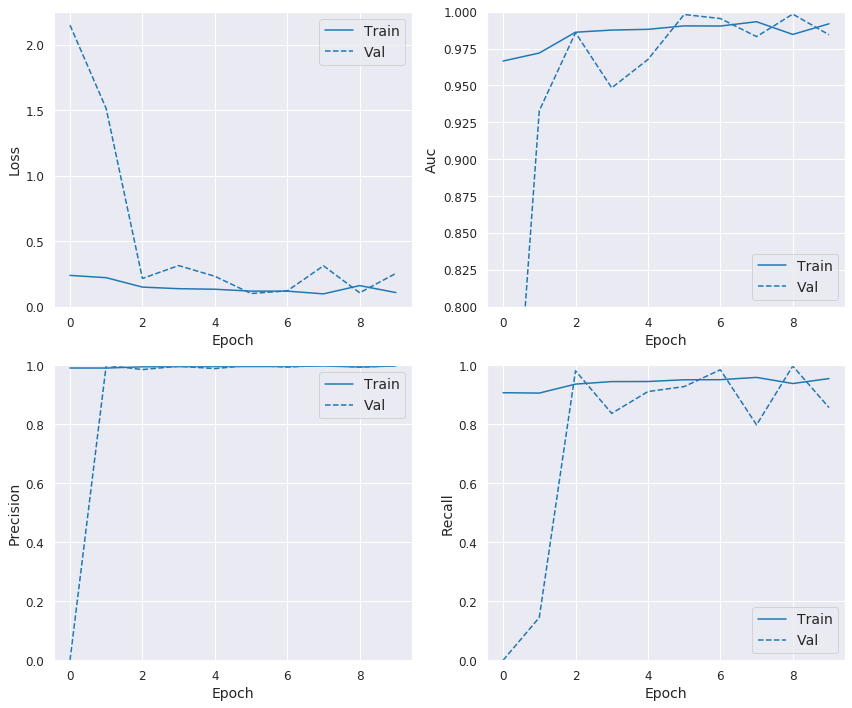

In [31]:
plot_metrics(weighted_history)
plt.savefig(conf["log_dir"]+"/weighted_metrics_plot.pdf", format="pdf")

In [32]:
weighted_results = weighted_model.evaluate(ds["val"], verbose=2, steps=conf["steps"]["val"])
print()

f = open(conf["log_dir"]+"/weighted_val_results.txt","w")
for name, value in zip(baseline_model.metrics_names, weighted_results):
    line = "{} : {}\n".format(name, value)
    print(line, end='')
    f.write(line)
f.close()
print()

100/100 - 2s - loss: 0.4040 - tp: 1249.0000 - fp: 3.0000 - tn: 146.0000 - fn: 202.0000 - accuracy: 0.8719 - precision: 0.9976 - recall: 0.8608 - auc: 0.9846

loss : 0.404011242055567
tp : 1249.0
fp : 3.0
tn : 146.0
fn : 202.0
accuracy : 0.871874988079071
precision : 0.9976038336753845
recall : 0.8607856631278992
auc : 0.9846090078353882



In [33]:
train_labels_weighted, train_predictions_weighted = numpify(ds["train"], weighted_model, samples=5000)
val_labels_weighted, val_predictions_weighted = numpify(ds["val"], weighted_model, samples=5000)

Legitimate Lesions Detected (True Negatives):  455
Legitimate Lesions Incorrectly Detected (False Positives):  12
Fraudulent Lesions Missed (False Negatives):  553
Fraudulent Lesions Detected (True Positives):  3980
Total Fraudulent Lesions:  4533



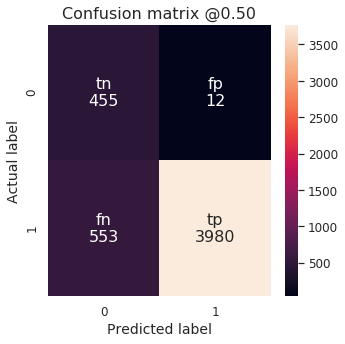

In [34]:
plot_cm(train_labels_weighted, train_predictions_weighted)
plt.savefig(conf["log_dir"]+"/weighted_cm_plot.pdf", format="pdf")

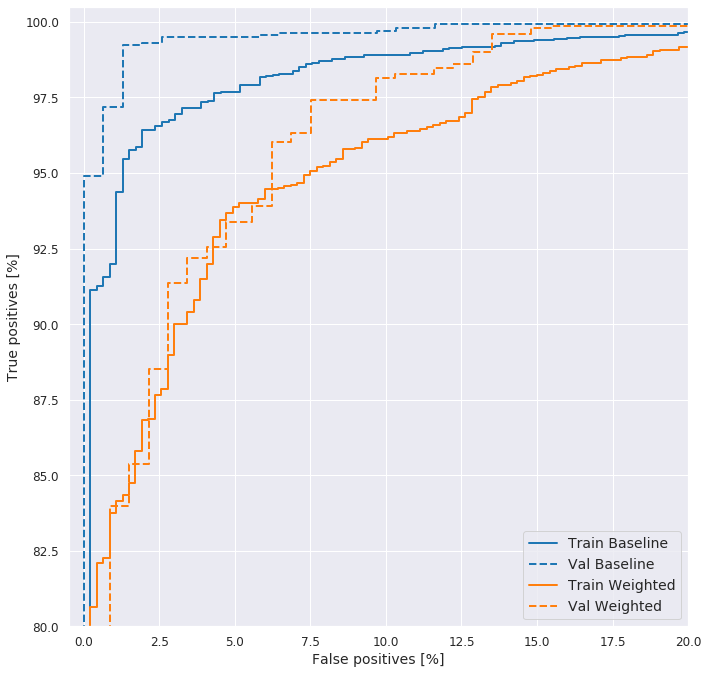

In [35]:
plt.figure(figsize=(10,10))

plot_roc("Train Baseline", train_labels_baseline, train_predictions_baseline, color=colors[0])
plot_roc("Val Baseline", val_labels_baseline, val_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels_weighted, train_predictions_weighted, color=colors[1])
plot_roc("Val Weighted", val_labels_weighted, val_predictions_weighted, color=colors[1], linestyle='--')

plt.legend(loc='lower right');
plt.savefig(conf["log_dir"]+"/weighted_roc_plot.pdf", format="pdf")

## Oversampling the minority class

In [36]:
# Remove the cache
!rm -rf ./cache/*

In [37]:
# Set dataset resample to true to make 5050 distribution of samples
conf["resample"] = True

Create training, testing and validation dataset from utils/data_prep.py

In [38]:
conf["num_classes"] = 2

In [39]:
ds_resampled = create_dataset(conf)


Negative                          :   999 | 9.37%
---------------------------------------------
     - pylorus                    :   999 | 9.37%

Positive                          :  9663 | 90.63%
---------------------------------------------
     - barretts-short-segment     :    53 | 0.50%
     - retroflex-stomach          :   764 | 7.17%
     - ulcerative-colitis-0-1     :    35 | 0.33%
     - ulcerative-colitis-grade-3 :   133 | 1.25%
     - esophagitis-b-d            :   260 | 2.44%
     - dyed-resection-margins     :   989 | 9.28%
     - hemorrhoids                :     6 | 0.06%
     - normal-z-line              :   932 | 8.74%
     - esophagitis-a              :   403 | 3.78%
     - ulcerative-colitis-1-2     :    11 | 0.10%
     - barretts                   :    41 | 0.38%
     - bbps-2-3                   :  1148 | 10.77%
     - ileum                      :     9 | 0.08%
     - bbps-0-1                   :   646 | 6.06%
     - impacted-stool             :   131 | 1.23%
    

In [40]:
# Check the mean value is close to 0.5
for img, label in ds_resampled["train"].take(3):
    print(label.numpy().mean())

0.5625
0.5
0.5


In [41]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

resampled_history = resampled_model.fit(
    ds_resampled["train"],
    steps_per_epoch = conf["steps"]["train"],
    epochs = conf["num_epochs"],
    validation_data = ds_resampled["test"],
    validation_steps = conf["steps"]["test"],
    validation_freq = 1,
    callbacks = callbacks
)

Train for 465 steps, validate for 99 steps
Epoch 1/10
465/465 [==============================] - 31s 66ms/step - loss: 0.1301 - tp: 3656.0000 - fp: 176.0000 - tn: 3464.0000 - fn: 144.0000 - accuracy: 0.9570 - precision: 0.9541 - recall: 0.9621 - auc: 0.9902 - val_loss: 1.2420 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 148.0000 - val_fn: 1436.0000 - val_accuracy: 0.0934 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7456
Epoch 2/10
465/465 [==============================] - 25s 54ms/step - loss: 0.0966 - tp: 3588.0000 - fp: 119.0000 - tn: 3613.0000 - fn: 120.0000 - accuracy: 0.9679 - precision: 0.9679 - recall: 0.9676 - auc: 0.9944 - val_loss: 0.4596 - val_tp: 1183.0000 - val_fp: 2.0000 - val_tn: 147.0000 - val_fn: 252.0000 - val_accuracy: 0.8396 - val_precision: 0.9983 - val_recall: 0.8244 - val_auc: 0.9832
Epoch 3/10
465/465 [==============================] - 25s 53ms/step - loss: 0.0391 - tp: 3693.0000 - fp: 43.0000 - tn: 3651.0000 - fn: 53.0000 - accuracy

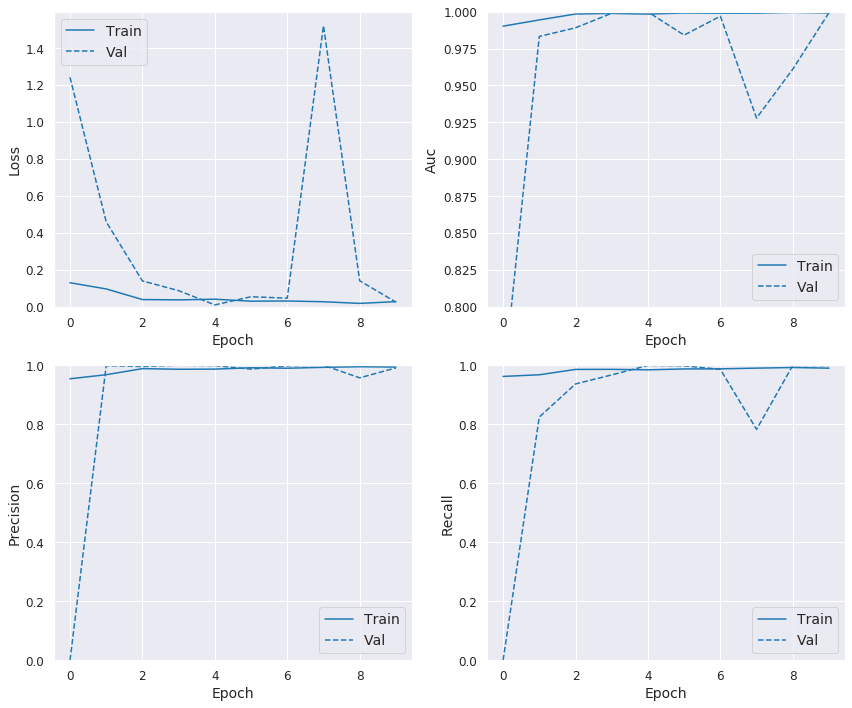

In [42]:
plot_metrics(resampled_history)
plt.savefig(conf["log_dir"]+"/resampled_metrics_plot.pdf", format="pdf")

In [43]:
resampled_results = resampled_model.evaluate(ds_resampled["val"], verbose=2, steps=conf["steps"]["val"])
print()

f = open(conf["log_dir"]+"/resampled_val_results.txt","w")
for name, value in zip(resampled_model.metrics_names, resampled_results):
    line = "{} : {}\n".format(name, value)
    print(line, end='')
    f.write(line)
f.close()
print()

100/100 - 2s - loss: 0.0201 - tp: 1447.0000 - fp: 8.0000 - tn: 142.0000 - fn: 3.0000 - accuracy: 0.9931 - precision: 0.9945 - recall: 0.9979 - auc: 0.9995

loss : 0.020054405186715484
tp : 1447.0
fp : 8.0
tn : 142.0
fn : 3.0
accuracy : 0.9931250214576721
precision : 0.9945017099380493
recall : 0.9979310631752014
auc : 0.9994528889656067



In [44]:
train_labels_resampled, train_predictions_resampled = numpify(ds_resampled["train"], resampled_model, samples=5000)
val_labels_resampled, val_predictions_resampled = numpify(ds_resampled["val"], resampled_model, samples=5000)

Legitimate Lesions Detected (True Negatives):  2222
Legitimate Lesions Incorrectly Detected (False Positives):  182
Fraudulent Lesions Missed (False Negatives):  5
Fraudulent Lesions Detected (True Positives):  2591
Total Fraudulent Lesions:  2596



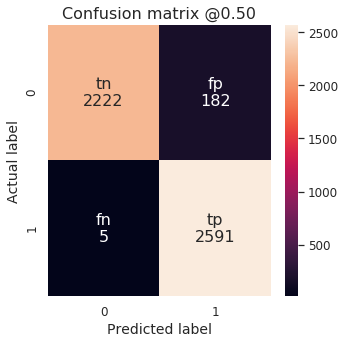

In [45]:
plot_cm(train_labels_resampled, train_predictions_resampled)
plt.savefig(conf["log_dir"]+"/resampled_cm_plot.pdf", format="pdf")

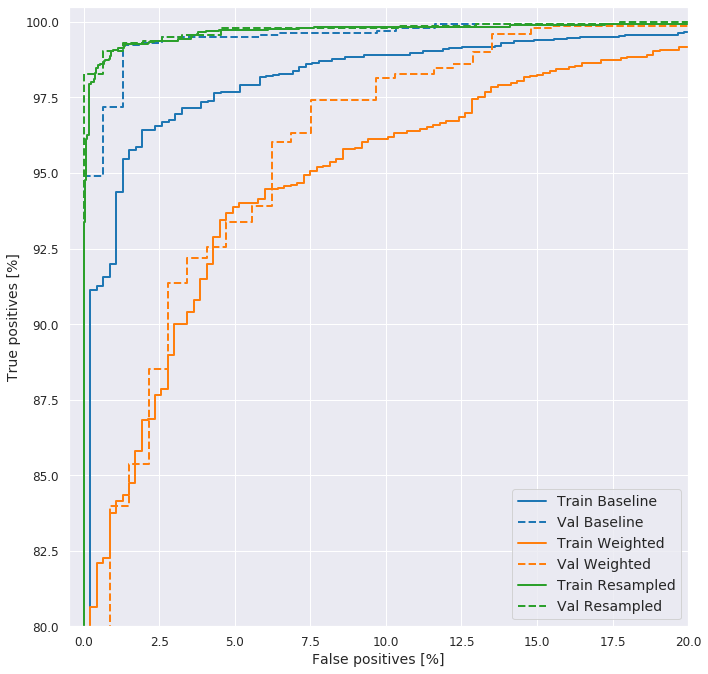

In [46]:
plt.figure(figsize=(10,10))

plot_roc("Train Baseline", train_labels_baseline, train_predictions_baseline, color=colors[0])
plot_roc("Val Baseline", val_labels_baseline, val_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels_weighted, train_predictions_weighted, color=colors[1])
plot_roc("Val Weighted", val_labels_weighted, val_predictions_weighted, color=colors[1], linestyle='--')

plot_roc("Train Resampled", train_labels_resampled, train_predictions_resampled, color=colors[2])
plot_roc("Val Resampled", val_labels_resampled, val_predictions_resampled, color=colors[2], linestyle='--')

plt.legend(loc='lower right');
plt.savefig(conf["log_dir"]+"/resampled_roc_plot.pdf", format="pdf")